In [4]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os
os.chdir("..")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["PYTHONHASHSEED"] = "0"
import importlib
import collections

from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", 0)

from snorkel.labeling import LabelingFunction, PandasLFApplier, LFAnalysis, filter_unlabeled_dataframe
from snorkel.labeling.model import LabelModel
from snorkel.utils import probs_to_preds

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from src.data.utils import load_youtube_spam_dataset

In [2]:
SEED = 123
np.random.seed(SEED)

In [3]:
ABSTAIN = -1
HAM = 0
SPAM = 1

In [5]:
ROOT_PATH = Path("/home/s2210421/dataset/youtube_spam_cmt")
df_train, df_val, df_test = load_youtube_spam_dataset(ROOT_PATH / "data", True)
Y_test = df_test.label.values

len(df_train), len(df_val), len(df_test)

(1586, 175, 195)

In [5]:
df_train_spam = df_train[df_train.label == 1]
df_train_ham = df_train[df_train.label == 0]

len(df_train_spam), len(df_train_ham)

(805, 761)

In [6]:
primitive_examples, primitive_labels = collections.defaultdict(list), collections.defaultdict(list)
for i, row in df_train.iterrows():
    words = list(set(row["text"].split()))
    for w in words:
        primitive_examples[w].append(i)
        primitive_labels[w].append(row["label"])

primitive_probs = {}
for w in primitive_labels.keys():
    primitive_examples[w] = set(primitive_examples[w])
    primitive_probs[w] = sum(primitive_labels[w]) / len(primitive_labels[w])

In [7]:
def keyword_lookup(x, keywords, label):
    if any(word in x.text.lower() for word in keywords):
        return label
    return -1


def make_keyword_lf(keywords, label):
    return LabelingFunction(
        name=f"keyword_{keywords[0]}",
        f=keyword_lookup,
        resources=dict(keywords=keywords, label=label))


def seu(df_train, prim_examples, lfs, prob_labels, pred_labels):
    cand_lfs = []

    vectorizer = TfidfVectorizer()
    X_train = vectorizer.fit_transform(df_train.text.tolist())


def select_dev_example(df, lfs=[], method="random"):
    retry_count = 0
    while True:
        example = df.sample(n=1).iloc[0]
        if len(lfs) and retry_count <= 5:
            if method == "abs":
                has_label = False
                for lf in lfs:
                    if lf(example) != -1:
                        has_label = True
                        break
                if has_label:
                    retry_count += 1
                    continue
            elif method == "dis":
                labels = []
                for lf in lfs:
                    l = lf(example)
                    if l != -1:
                        labels.append(l)
                if len(labels) != 0:
                    conf = np.mean(labels)
                    if conf < 0.4 or conf > 0.7:
                        retry_count += 1
                        continue
            elif method == "seu":
                pass

        return example


def select_primitive(example, selected_prim, prim_probs, prim_thresh, use_weight_probs=False):
    words = example.text.lower().split()
    cands, cands_w = [], []
    for w in words:
        if w not in prim_probs or w in selected_prim:
            continue

        if (example.label == 0 and prim_probs[w] < 1 - prim_thresh) or \
           (example.label == 1 and prim_probs[w] > prim_thresh):
            cands.append(w)
            if example.label == 1:
                cands_w.append(prim_probs[w])
            else:
                cands_w.append(1 - prim_probs[w])
    if len(cands) == 0:
        return None
    cands_prob = np.exp(cands_w) / np.sum(np.exp(cands_w), axis=0)
    if use_weight_probs:
        prim = np.random.choice(cands, size=1, p=cands_prob)[0]
    else:
        prim = np.random.choice(cands, size=1)[0]
    return prim


def build_primitive_lf(df, lfs, select_method, selected_prim, prim_probs, prim_thres,
                       use_weight_probs=False):
    prim, example = None, None
    while prim is None:
        example = select_dev_example(df, lfs, select_method)
        prim = select_primitive(example, selected_prim, prim_probs, prim_thres, use_weight_probs)
    return make_keyword_lf(keywords=[prim], label=example.label), (prim, example.label)

In [9]:
config = {
    "num_trials": 50,

    "dataset": "ytb",
    "dataset_path": "/home/s2210421/dataset/youtube_spam_cmt",

    "num_iter": 50,
    "eval_iter_mod": 5,
    "alternative_draw": False,
    "select_method": "random",
    "primitive_threshold": 0.7
}

In [21]:
lfs, selected_prim = [], {}
use_weight_probs = False

segment_df = None
segment_flag = False

for iter in range(1, config["num_iter"] + 1):
    if iter == 1:
        for _ in range(3):
            if config["alternative_draw"]:
                segment_df = df_train_spam if segment_flag else df_train_ham
                segment_flag = not segment_flag
            else:
                segment_df = df_train
            lf, prim = build_primitive_lf(segment_df, lfs, config["select_method"], selected_prim, primitive_probs,
                                          config["primitive_threshold"], use_weight_probs)
            lfs.append(lf)
            selected_prim[prim[0]] = prim[1]
    else:
        if config["alternative_draw"]:
            segment_df = df_train_spam if segment_flag else df_train_ham
            segment_flag = not segment_flag
        else:
            segment_df = df_train
        lf, prim = build_primitive_lf(segment_df, lfs, config["select_method"], selected_prim, primitive_probs,
                                      config["primitive_threshold"], use_weight_probs)
        lfs.append(lf)
        selected_prim[prim[0]] = prim[1]

    if iter % config["eval_iter_mod"] == 0:
        applier = PandasLFApplier(lfs=lfs)
        L_train = applier.apply(df=df_train, progress_bar=False)
        L_test = applier.apply(df=df_test, progress_bar=False)

        label_model = LabelModel(cardinality=2, verbose=False)
        label_model.fit(L_train=L_train, n_epochs=500, progress_bar=False)
        lm_acc = label_model.score(
            L=L_test, Y=df_test.label.values, tie_break_policy="random")["accuracy"] * 100

        prob_labels = label_model.predict_proba(L=L_train)
        df_train_filtered, prob_labels_filtered = filter_unlabeled_dataframe(
            X=df_train, y=prob_labels, L=L_train)

        vectorizer = TfidfVectorizer()
        X_train = vectorizer.fit_transform(df_train_filtered.text.tolist())
        X_test = vectorizer.transform(df_test.text.tolist())

        lm_labels = probs_to_preds(probs=prob_labels_filtered)
        end_model = LogisticRegression(C=1e3, solver="liblinear")
        end_model.fit(X=X_train, y=lm_labels)
        em_acc = end_model.score(X=X_test, y=df_test.label.values) * 100

        lf_analysis = LFAnalysis(L=L_train, lfs=lfs)

        print(f"Iter {iter} - LM: {lm_acc:.4f} - EM: {em_acc:.4f}")

Iter 5 - LM: 70.2564 - EM: 62.0513
Iter 10 - LM: 74.3590 - EM: 60.0000
Iter 15 - LM: 65.1282 - EM: 77.9487
Iter 20 - LM: 67.1795 - EM: 81.0256
Iter 25 - LM: 67.1795 - EM: 74.3590
Iter 30 - LM: 67.1795 - EM: 66.6667
Iter 35 - LM: 65.1282 - EM: 63.0769
Iter 40 - LM: 68.2051 - EM: 64.6154
Iter 45 - LM: 68.2051 - EM: 65.6410
Iter 50 - LM: 68.7179 - EM: 64.6154


In [62]:
from matplotlib import pyplot as plt

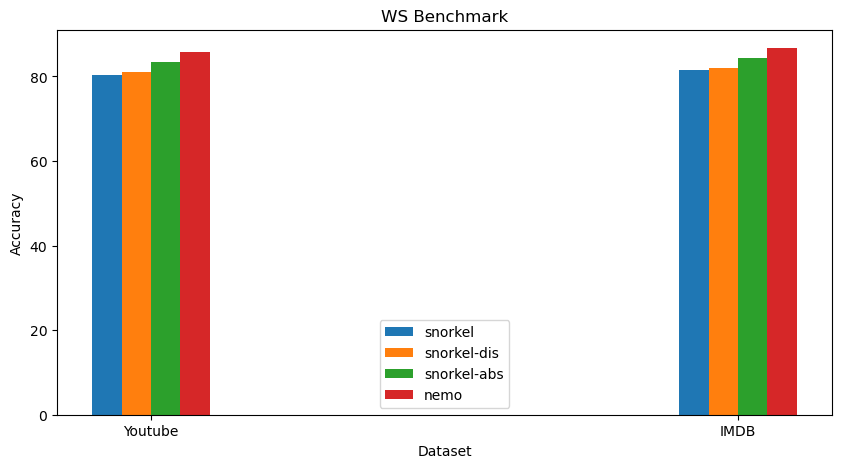

In [79]:
fig = plt.figure(figsize=(10, 5))

snorkel_acc = (80.4, 81.4)
snorkel_dis = (81, 82)
snorkel_abs = (83.3, 84.3)
nemo = (85.7, 86.7)

N = 2
ind = np.arange(N)

width = 0.05

for i, d in enumerate(zip([snorkel_acc, snorkel_dis, snorkel_abs, nemo],
                          ["snorkel", "snorkel-dis", "snorkel-abs", "nemo"])):
    plt.bar(ind + i * width, d[0], width, label=d[1])

plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.title('WS Benchmark')

plt.xticks(ind + 1.5 * width, ("Youtube", "IMDB"))

plt.legend(loc='best')
plt.show()